# Image Generation with Variational Autoencoders

We'll build a variational autoencoder (VAE) to generate images of handwritten digits inspired by the MNIST dataset.

## The MNIST dataset

The MNIST dataset consists of grayscale images of hand-written digits from 0 to 9. Each image is 28 pixels by 28 pixels. There're 60,000 training images and 10,000 test images.

We've organized these images in two folders named `train` and `test` in the GitHub repository https://github.com/DeepTrackAI/MNIST_dataset:

In [1]:
import os

if not os.path.exists("MNIST_dataset"):
    os.system("git clone https://github.com/DeepTrackAI/MNIST_dataset")

dir = os.path.join("MNIST_dataset", "mnist", "train")

In [2]:
print(f"{len(os.listdir(dir))} training images")

60000 training images


We load the data using `Deeptrack2.0`. We will only use `6000` images for training and `6000` for test. We normalize the images in the range `[0, 1]`

In [3]:
import deeptrack as dt
import torch

files = dt.sources.ImageFolder(root=dir)
train_files, test_files, _ = dt.sources.random_split(files, [0.1, 0.1, 0.8])

train_pipeline = (
    dt.LoadImage(train_files.path)
    >> dt.NormalizeMinMax()
    >> dt.MoveAxis(2, 0)
    >> dt.pytorch.ToTensor(dtype=torch.float)
)

2024-01-30 21:10:44.856416: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


We will randomly choose and visualize some of the images in the dataset

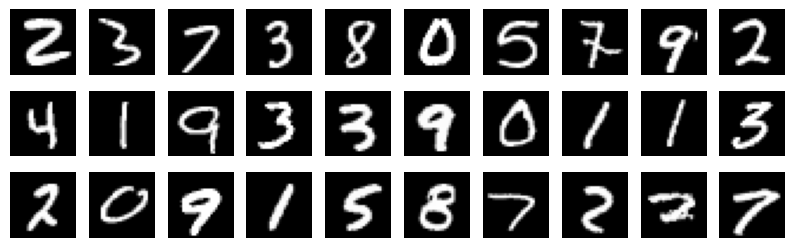

In [4]:
import matplotlib.pyplot as plt
import numpy as np

fig, axs = plt.subplots(3, 10, figsize=((10, 3)))
for ax, train_file in zip(axs.ravel(), np.random.choice(train_files, axs.size)):
    image = train_pipeline(train_file)
    ax.imshow(image.squeeze(), cmap="gray")
    ax.set_axis_off()

## Variational autoencoder
We define the autoencoder architecture with a bidimensional latent space.

In [5]:
import deeplay as dl
import torchmetrics as tm

vae = dl.VariationalAutoEncoder(latent_dim=2).create()

print(vae)

VariationalAutoEncoder(
  (encoder): ConvolutionalEncoder2d(
    (blocks): LayerList(
      (0): PoolLayerActivationNormalization(
        (pool): Identity()
        (layer): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (activation): ReLU()
        (normalization): Identity()
      )
      (1): PoolLayerActivationNormalization(
        (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (layer): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (activation): ReLU()
        (normalization): Identity()
      )
      (2): PoolLayerActivationNormalization(
        (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (layer): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (activation): ReLU()
        (normalization): Identity()
      )
    )
    (postprocess): Flatten(start_dim=1, end_dim=-1)
  )
  (fc_mu): Linear(in_features=3136, out_f

We define the datasets, the dataloader and the trainer. We train the autoencder for `100` epochs.

In [6]:
from torch.utils.data import DataLoader

train_dataset = dt.pytorch.Dataset(train_pipeline & train_pipeline, 
                                   inputs=train_files)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
vae_trainer = dl.Trainer(max_epochs=100, accelerator="auto")
vae_trainer.fit(vae, train_loader)

INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
/Users/giovannivolpe/miniconda3/envs/py310/lib/python3.10/site-packages/lightning/pytorch/trainer/configuration_validator.py:74: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
INFO: 
  | Name                | Type                   | Params
---------------------------------------------------------------
0 | encoder             | ConvolutionalEncoder2d | 55.7 K
1 | fc_mu               | Linear                 | 6.3 K 
2 | fc_var              | Linear                 | 6.3 

Training: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=100` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=100` reached.


## Image Generation
We generate images by sampling a continuous distribution of latent representations and reconstructing the images using the trained VAE’s decoder.

In [35]:
start

14

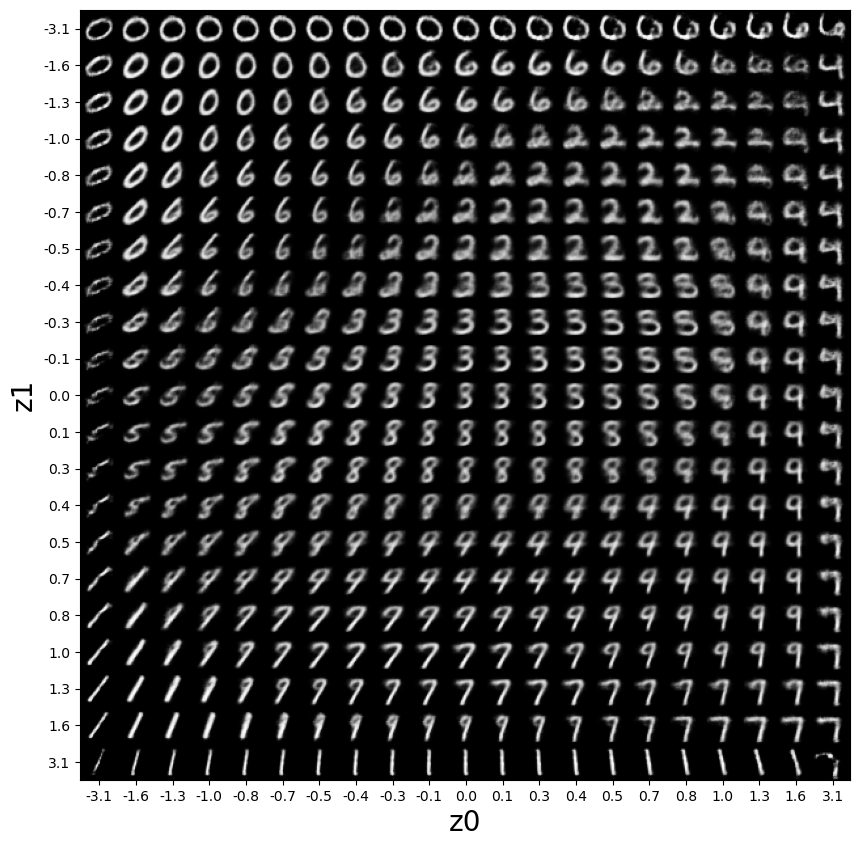

In [37]:
from torch.distributions.normal import Normal

img_num, img_size = 21, 28

z0_grid = Normal(0, 1).icdf(torch.linspace(0.001, 0.999, img_num))
z1_grid = Normal(0, 1).icdf(torch.linspace(0.001, 0.999, img_num))

image = np.zeros((img_num * img_size, img_num * img_size))

for i0, z0 in enumerate(z0_grid):
    for i1, z1 in enumerate(z1_grid):
        z = torch.stack((z0, z1)).unsqueeze(0)
        generated_image = vae.decode(z).clone().detach()
        image[
            i1 * img_size : (i1 + 1) * img_size,
            i0 * img_size : (i0 + 1) * img_size,
        ] = generated_image.numpy().squeeze()

plt.figure(figsize=(10, 10))
plt.imshow(image, cmap="gray")
plt.xticks(np.arange(0.5 * img_size, (0.5 + img_num) * img_size, img_size), 
           np.round(z0_grid.numpy(), 1))
plt.yticks(np.arange(0.5 * img_size, (0.5 + img_num) * img_size, img_size), 
           np.round(z1_grid.numpy(), 1))
plt.xlabel("z0", fontsize=20)
plt.ylabel("z1", fontsize=20)
plt.show()

## Clustering in the latent space
We will use the VAE as a clustering algorithm, i.e., to cluster the input images into different classes with respect to the latent space encoding.

We define a pipeline to get images and labels of the test dataset.

In [8]:
test_pipeline = (
    dt.LoadImage(test_files.path)
    >> dt.NormalizeMinMax()
    >> dt.MoveAxis(2, 0)
    >> dt.pytorch.ToTensor(dtype=torch.float)
)

In [9]:
def get_label(label_name):
    """Get image label."""
    return int(label_name[0])

test_label = dt.Value(get_label, label_name=test_files.label_name)

In [10]:
test_dataset = dt.pytorch.Dataset(test_pipeline & test_label, inputs=test_files)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

We encode the images of the test dataset into latent space representation.

In [40]:
z_list, test_labels = [], []
for image, label in test_loader:
    z, _ = vae.encode(image)
    z_list.append(z)
    test_labels.append(label)
z_tensor = torch.cat(z_list, dim=0).detach().numpy()
test_labels = torch.cat(test_labels, dim=0).numpy()

We plot the latent-space representation, color coded according to the image label.

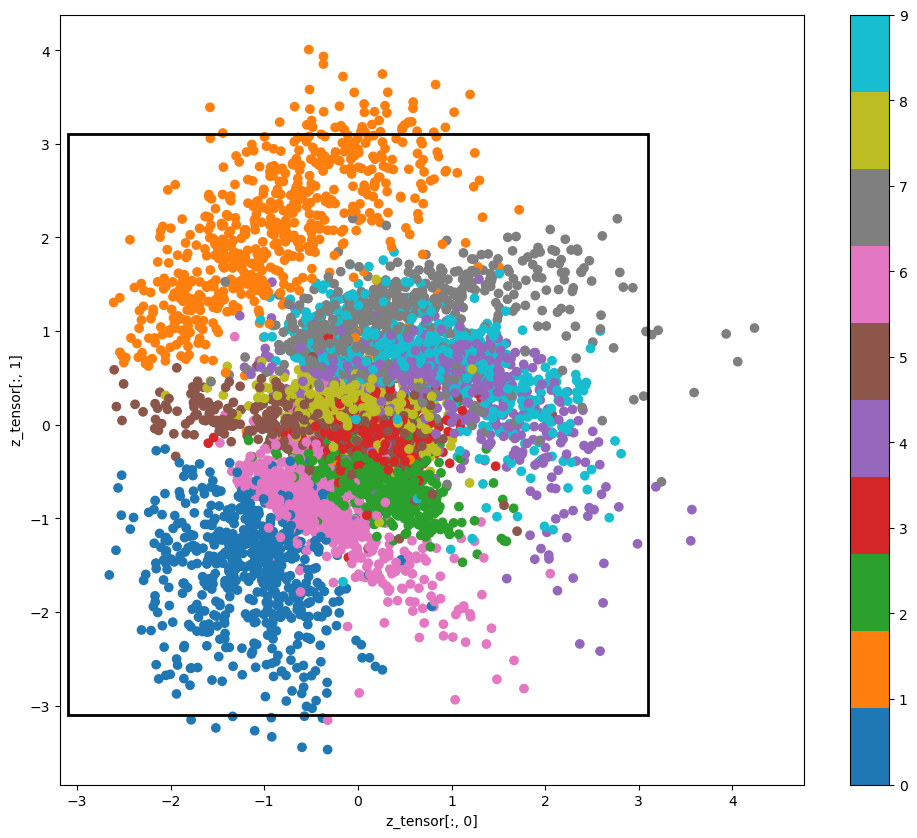

In [46]:
from matplotlib.patches import Rectangle

plt.figure(figsize=(12, 10))
plt.scatter(z_tensor[:, 0], z_tensor[:, 1], c=test_labels, cmap="tab10")
plt.xlabel("z_tensor[:, 0]")
plt.ylabel("z_tensor[:, 1]")
plt.colorbar()
plt.axis('equal')
plt.gca().add_patch(Rectangle((-3.1, -3.1), 6.2, 6.2, fc="none", ec="k", lw=1))
plt.show()